# Zadania

In [1]:
# Two-class MNIST 

import os
import numpy as np
os.environ['KERAS_BACKEND'] = 'theano'
from keras.datasets import mnist

d1 = 5
d2 = 6

(mnist_x_train, mnist_y_train), (mnist_x_test, mnist_y_test) = mnist.load_data()

X_train = (mnist_x_train.astype('float32') / 255.).reshape((len(mnist_x_train), np.prod(mnist_x_train.shape[1:])))
y_train = mnist_y_train
X_test = (mnist_x_test.astype('float32') / 255.).reshape((len(mnist_x_test), np.prod(mnist_x_test.shape[1:])))
y_test = mnist_y_test

X_train = X_train[np.logical_or(y_train == d1, y_train == d2)]
y_train = y_train[np.logical_or(y_train == d1, y_train == d2)]
y_train[y_train==d1] = 0
y_train[y_train==d2] = 1
X_test = X_test[np.logical_or(y_test == d1, y_test == d2)]
y_test = y_test[np.logical_or(y_test == d1, y_test == d2)]
y_test[y_test==d1] = 0
y_test[y_test==d2] = 1

print X_train.shape
print X_test.shape


Using Theano backend.


(11339L, 784L)
(1850L, 784L)


## Ćwiczenie 1 [5 pkt]

Uzupełnij metody forward_pass oraz backward_pass w klasach ReLU, Sigmoid i Dense. Metoda forward_pass ma przyjmować batch inputów i zwracać batch outputów. Metoda backward_pass ma przyjmować batch inputów oraz batch pochodnych cząstkowych outputów i zwracać batch pochodnych cząstkowych inputów oraz wektor (**nie batch**) pochodnych cząstkowych wag. Jeśli wagi przechowujemy w macierzy dwuwymiarowej, to możemy najpierw policzyć pochodne cząstkowe w macierzy o takim samym kształcie, a następnie np. użyć .flat. 

Uwaga: dla warstw bez wag należy zwrócić None.

## Ćwiczenie 2 [4 pkt]

Uzupełnij metodę _forward_pass klasy Network. Metoda ta ma przyjmować batch inputów (X) i zwracać dwie rzeczy:
* inps - lista batchów inputów dla każdej warstwy w sieci (włącznie z X); te wartości będziemy używali w metodzie _backward_pass
* output - batch outputów z sieci (czyli $\mathbf{\hat y}$); output **nie** powinien być ostatnim elementem inps.

## Ćwiczenie 3 [5 pkt]

Uzupełnij metodę _backward_pass klasy Network. Zwróć uwagę, że pochodna funkcji kosztu po neuronach ostatniej warstwy jest już liczona w metodzie _fit_on_batch. Metoda ma zwracać listę layer_grads, której elementy to wektory pochodnych cząstkowych funkcji kosztu po kolejnych warstwach (zwrócone przez metodę Layer.backward_pass). Kolejność wektorów w tej liście ma być zgodna z kolejnością warstw w sieci.

## Ćwiczenie 4 [3 pkt]
Naucz sieć neuronową z jedną warstwą ukrytą i aktywacją Sigmoid na powyższych danych (dwuklasowy MNIST). Użyj MSE jako funkcji kosztu (oznacza to regresję do numeru klasy, co jest złym pomysłem, ale póki nie mamy klasy Crossentropy musi nam to wystarczyć). Użyj GD. Reportuj loss oraz accuracy.

## Ćwiczenie 5 [3 pkt]
Uzupełnić klasę Crossentropy, wzorując się na klasie MSE.

## Ćwiczenie  6 [3 pkt]
Uzupełnić klasę Momentum, wzorując się na klasie GD. Wzory można znaleźć tutaj: http://distill.pub/2017/momentum/

## Ćwiczenie 7 [3 pkt]
Naucz sieć neuronową z jedną warstwą ukrytą. Rozważ dwa przypadki: aktywację ReLU oraz Sigmoid. Czy jest sens używać ReLU jako ostatnią warstwę? Użyj Crossentropy jako funkcji kosztu. Użyj Momentum. Reportuj loss oraz accuracy.

## Ćwiczenie 8 [6 pkt]
Vanishing gradient.

Zadanie polega na zbadaniu zjawiska *vanishing gradient* w głębokich sieciach. Należy zmodyfikować kod warstwy Dense i dodać monitorowanie **normy euklidesowej** wektora delta_weights. Każdą warstwę Dense w trenowanej sieci należy monitorować oddzielnie. Po każdym wywołaniu metody fit_on_batch każdy z monitorów powinien zapamiętać nową normę. Po nauczeniu sieci dla każdej warstwy należy narysować wykres: poziomo - numer wywołania fit_on_batch, pionowo - norma delta_weights. Im niżej znajduje się warstwa Dense, tym silniej będzie zachodziło zjawisko *vanishing gradient*.

Naucz dwuwarstwową sieć z aktywacjami Sigmoid, reportując normy delta_weights. Powtórz to dla głębszej sieci (np. 6-10 warstw).

## Ćwiczenie 9 [4 pkt]
Przetestować kod z ćwiczenia 7. (dwuwarstwowa sieć) stosując inne inicjalizacje wag w warstwach Dense. Napisać własną inicjalizację wag, która sprawi, że sieć niczego się nie nauczy (init='stupid').


In [14]:
# Warstwy
import sys
class Layer():

    def forward_pass(self, input):
        # return output
        raise NotImplementedError()

    def backward_pass(self, input, output_grad):
        # return input_grad, weight_grad
        raise NotImplementedError()

    def update_weights(self, delta_weights):
        pass

    def debug_grad(self, evaluate_loss):
        return None

class ReLU(Layer):

    def forward_pass(self, input):
        return np.maximum(input, 0);
        
    def backward_pass(self, input, output_grad):
        ret = np.multiply(output_grad, (np.asmatrix(input) > 0))
        return ret, None
    
    def get_monitor(self):
        return None

class Sigmoid(Layer):

    def forward_pass(self, input):
        #print input
        return   1 / (1 + np.exp(-input))

    def backward_pass(self, input, output_grad):
        #print input
        out = np.multiply(np.multiply(output_grad, self.forward_pass(input)), (1 - self.forward_pass(input)))
        #print out
        return np.nan_to_num(out),None
    
    def get_monitor(self):
        return None
class Dense(Layer):

    def __init__(self, input_size, output_size, init = 'gaussian'):
        input_size += 1
        if init == 'zeros':
            self.weights = np.zeros((input_size, output_size))
        elif init == 'gaussian':
            self.weights = np.random.normal(
                0.,
                2. / (input_size + output_size),
                (input_size, output_size)
            )
        elif init == 'stupid':
            # Ćwiczenie 8
            self.weights = np.full((input_size, output_size), sys.float_info.min)
            #print self.weights
        else:
            raise NotImplementedError()
        self.weights = np.asmatrix(self.weights)
        self.monitor = []

    def forward_pass(self, input):
        column = np.array([np.ones(input.shape[0])])

        input = np.append( column.T ,input, 1)
        
        out = input.dot(self.weights)
        return out
    
    def backward_pass(self, input, output_grad):
        #print input.shape
        column = np.array([np.ones(input.shape[0])])

        input = np.append( column.T ,input, 1)
        
        weight_grad = input.T.dot(output_grad)
        input_grad = output_grad.dot(self.weights.T)
        
        return input_grad[:,1:], np.array(weight_grad.flat)

    def update_weights(self, delta_weights):
        # Ćwiczenie 7 - monitorowanie normy wektora delta_weights
        #print delta_weights.shape
        self.monitor.append(np.linalg.norm(delta_weights))
        #print np.average(self.weights.T)
        self.weights += delta_weights.reshape(self.weights.shape)

    def get_monitor(self):
        return self.monitor
    
    def debug_grad(self, evaluate_loss):
        base = evaluate_loss()
        grad = []
        for (x, y), w in np.ndenumerate(self.weights):
            self.weights[x, y] = w + 0.0001
            changed = evaluate_loss()
            grad.append(10000. * (changed - base))
            self.weights[x, y] = w
        return grad

In [3]:
# Optimizers

class Optimizer():

    def calculate_deltas(self, grad):
        raise NotImplementedError()

class GD(Optimizer):

    def __init__(self, learning_rate):
        self.learning_rate = learning_rate

    def calculate_deltas(self, grad):
        return -self.learning_rate * grad

class Momentum(Optimizer):

    def __init__(self, alpha, beta):
        self.alpha = alpha
        self.beta = beta
        self.z = 0
        
    def calculate_deltas(self, grad):
        # Ćwiczenie 6
        self.z = self.beta*self.z + grad
        return -self.alpha*self.z

In [22]:
# Funkcje kosztu

class Loss():

    def forward_pass(self, y, t):
        # return cost
        raise NotImplementedError()

    def backward_pass(self, y, t):
        # return y_grad
        raise NotImplementedError()

class MSE(Loss):

    def forward_pass(self, y, t):
        #print y
        out = np.average(0.5 * np.square(y - t))
        return out

    def backward_pass(self, y, t):
        return (y - t) / y.size

class Crossentropy(Loss):

    def forward_pass(self, y, t):
        first = np.multiply(-t,np.log(y))
        sec = np.multiply((1-t),np.log(1-y))
        sum = np.sum(np.nan_to_num(first-sec))
        return sum / len(t)
        # Ćwiczenie 5
        
    def backward_pass(self, y, t):
        # Ćwiczenie 5
        return (-(t/y) + ((1-t)/(1-y)))/len(t)


In [15]:
class Network():

    def __init__(self, loss, optimizer, metrics = []):
        self.layers = []
        self.loss = loss
        self.optimizer = optimizer
        self.metrics = metrics

    def add(self, layer):
        self.layers.append(layer)

    def fit(self, X, t, epochs, batch_size=256, print_stats=False):
        X = np.array(X)
        t = np.array(t)
        X = X.reshape(len(X), -1)
        t = t.reshape(len(t), -1)
        if X.shape[0] != t.shape[0]:
            raise ValueError("Array sizes don't match")

        for epoch in range(epochs):
            if print_stats:
                print("Epoch %d" % (epoch+1))
                print("    -> batch size: %d" % batch_size)
            rng_state = np.random.get_state()
            np.random.shuffle(X)
            np.random.set_state(rng_state)
            np.random.shuffle(t)
            pos = 0
            while pos < len(X):
                batch_X = X[pos:pos+batch_size]
                batch_t = t[pos:pos+batch_size]
                self._fit_on_batch(batch_X, batch_t)
                pos += batch_size
            if print_stats:
                _, y = self._forward_pass(X)
                l = self.loss.forward_pass(y, t)
                print("    -> loss: %f" % l)
                for m in self.metrics:
                    print("    -> %s: %f" % (m.__name__, m(y, t)))

    def predict(self, X):
        inps, out = self._forward_pass(X)
        return out

    def _fit_on_batch(self, batch_X, batch_t):
        inps, out = self._forward_pass(batch_X)
        layer_grads = self._backward_pass(
            inps,
            self.loss.backward_pass(out, batch_t)
        )
        #print layer_grads
        grad = self._join(layer_grads)
        #print grad.shape
        deltas = self.optimizer.calculate_deltas(grad)
        for l, d in zip(self.layers, self._split(deltas, layer_grads)):
            if not d is None:
                l.update_weights(d)

    def _join(self, grads):
        return np.concatenate([g for g in grads if not g is None])

    def _split(self, grads, layer_grads):
        out = []
        start = 0
        for l in layer_grads:
            if l is None:
                out.append(None)
            else:
                out.append(grads[start:start+len(l)])
                start += len(l)
        return out

    def _forward_pass(self, X):
        inps = []
        output = None
        inps.append(X)
        for l in self.layers:
            X = l.forward_pass(X)
            inps.append(X)
        output = inps[-1]    
        inps = inps[:-1]
        # Ćwiczenie 2
        #print output
        return inps, output

    def _backward_pass(self, inps, grad):
        layer_grads = []
        reverted = list(reversed(self.layers))
        reversedInps = list(reversed(inps))
        #print inps
        #print grad.shape
        for i in range(len(reverted)):
            grad, wGrad = reverted[i].backward_pass(reversedInps[i],grad)
            
            if wGrad == None:
                layer_grads.append(None)
            else:        
                layer_grads.append(wGrad)
        #print layer_grads
        # Ćwiczenie 3
        return list(reversed(layer_grads))

    def _debug_grads(self, X, t):
        layer_grads = []
        for l in self.layers:
            g = l.debug_grad(
                lambda: self.loss.forward_pass(self._forward_pass(X)[1], t)
            )
            if not g is None:
                g = np.array(np.array(g).flat)
            layer_grads.append(g)
        return layer_grads

In [24]:
# Ćwiczenie 4
net = Network(MSE(),GD(0.1))

net.add(Dense(784,10))
net.add(Sigmoid())

net.add(Dense(10,1))
net.add(Sigmoid())

net.fit(X_train,y_train,15,batch_size=100,print_stats=True)

Epoch 1
    -> batch size: 100


C:\Users\getti\Anaconda2\lib\site-packages\ipykernel\__main__.py:95: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


    -> loss: 0.111402
Epoch 2
    -> batch size: 100
    -> loss: 0.087504
Epoch 3
    -> batch size: 100
    -> loss: 0.061189
Epoch 4
    -> batch size: 100
    -> loss: 0.043767
Epoch 5
    -> batch size: 100
    -> loss: 0.033757
Epoch 6
    -> batch size: 100
    -> loss: 0.027810
Epoch 7
    -> batch size: 100
    -> loss: 0.024018
Epoch 8
    -> batch size: 100
    -> loss: 0.021433
Epoch 9
    -> batch size: 100
    -> loss: 0.019571
Epoch 10
    -> batch size: 100
    -> loss: 0.018168
Epoch 11
    -> batch size: 100
    -> loss: 0.017074
Epoch 12
    -> batch size: 100
    -> loss: 0.016210
Epoch 13
    -> batch size: 100
    -> loss: 0.015492
Epoch 14
    -> batch size: 100
    -> loss: 0.014895
Epoch 15
    -> batch size: 100
    -> loss: 0.014394


In [26]:
# Ćwiczenie 7
net = Network(Crossentropy(),Momentum(0.2,0.2))

net.add(Dense(784,100))
net.add(Sigmoid())


net.add(Dense(100,1))
net.add(Sigmoid())

net.fit(X_train,y_train,10,batch_size=100,print_stats=True)

Epoch 1
    -> batch size: 100


C:\Users\getti\Anaconda2\lib\site-packages\ipykernel\__main__.py:95: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


    -> loss: -10.779621
Epoch 2
    -> batch size: 100
    -> loss: -10.798143
Epoch 3
    -> batch size: 100
    -> loss: -10.047381
Epoch 4
    -> batch size: 100
    -> loss: -8.961584
Epoch 5
    -> batch size: 100
    -> loss: -6.659406
Epoch 6
    -> batch size: 100
    -> loss: -6.050430
Epoch 7
    -> batch size: 100
    -> loss: -8.059664
Epoch 8
    -> batch size: 100
    -> loss: -6.004918
Epoch 9
    -> batch size: 100
    -> loss: -6.795838
Epoch 10
    -> batch size: 100
    -> loss: -6.908225


Moim zdaniem wszystko zależy od konkretnego przypadku, ale w wiekszości wydaje mi się, że użycie ReLU w ostatniej warstwie nie jest dobre. Powoduje to spłaszczenie wszystkich ujemnych wyników do 0. Tracimy w ten sposób informacje o ujemnych wynikach.

In [38]:
# Ćwiczenie 7
net = Network(Crossentropy(),Momentum(0.2,0.2))

net.add(Dense(784,100))
net.add(ReLU())


net.add(Dense(100,1))
net.add(ReLU())

net.fit(X_train,y_train,10,batch_size=100,print_stats=True)

Epoch 1
    -> batch size: 100


C:\Users\getti\Anaconda2\lib\site-packages\ipykernel\__main__.py:95: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


    -> loss: 0.000000
Epoch 2
    -> batch size: 100
    -> loss: 0.000000
Epoch 3
    -> batch size: 100
    -> loss: 0.000000
Epoch 4
    -> batch size: 100
    -> loss: 0.000000
Epoch 5
    -> batch size: 100
    -> loss: 0.000000
Epoch 6
    -> batch size: 100
    -> loss: 0.000000
Epoch 7
    -> batch size: 100
    -> loss: 0.000000
Epoch 8
    -> batch size: 100
    -> loss: 0.000000
Epoch 9
    -> batch size: 100
    -> loss: 0.000000
Epoch 10
    -> batch size: 100
    -> loss: 0.000000


C:\Users\getti\Anaconda2\lib\site-packages\ipykernel\__main__.py:95: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


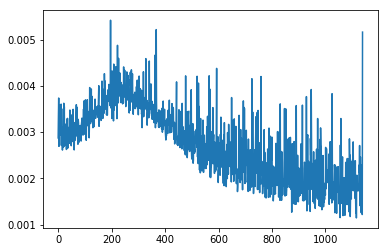

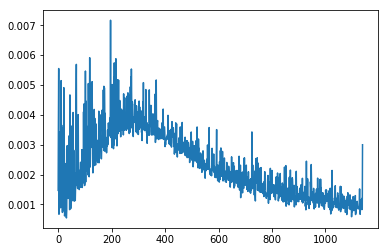

In [30]:
import matplotlib.pylab as plt # Import podpakietu jako plt
# Magia IPython Notebook :) Pokazuje wykresy w konsoli
%matplotlib inline 
# Ćwiczenie 8
net = Network(MSE(),GD(0.1))

net.add(Dense(784,10))
net.add(Sigmoid())

net.add(Dense(10,1))
net.add(Sigmoid())

net.fit(X_train,y_train,10,batch_size=100,print_stats=False)

for l in net.layers:
    monitor = l.get_monitor()
    if monitor != None:
        plt.plot(range(0,len(l.monitor)),l.monitor)
        plt.show()
        

C:\Users\getti\Anaconda2\lib\site-packages\ipykernel\__main__.py:95: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


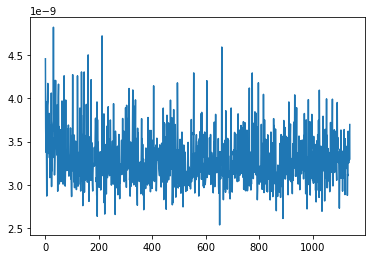

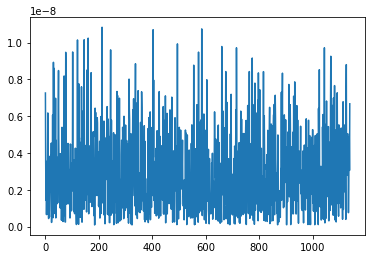

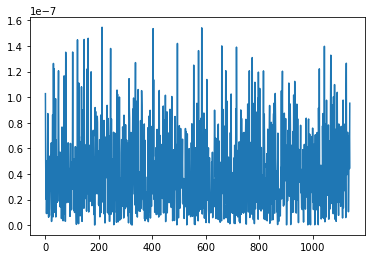

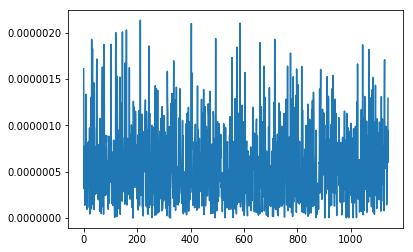

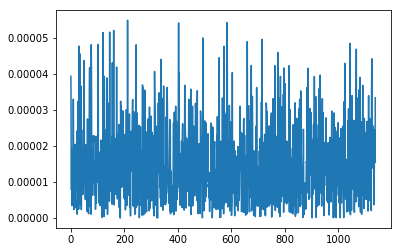

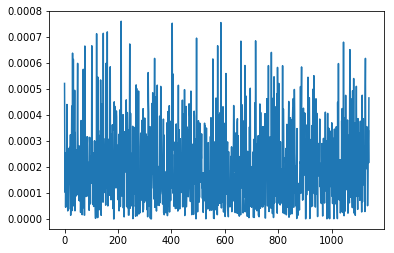

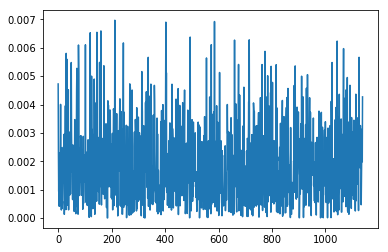

In [32]:
net = Network(MSE(),GD(0.1))

net.add(Dense(784,10))
net.add(Sigmoid())

net.add(Dense(10,10))
net.add(Sigmoid())

net.add(Dense(10,10))
net.add(Sigmoid())

net.add(Dense(10,10))
net.add(Sigmoid())

net.add(Dense(10,10))
net.add(Sigmoid())

net.add(Dense(10,10))
net.add(Sigmoid())

net.add(Dense(10,1))
net.add(Sigmoid())

net.fit(X_train,y_train,10,batch_size=100,print_stats=False)

for l in net.layers:
    monitor = l.get_monitor()
    if monitor != None:
        plt.plot(range(0,len(l.monitor)),l.monitor)
        plt.show()

In [40]:
# Ćwiczenie 9
net = Network(Crossentropy(),Momentum(0.1,0.5))


net.add(Dense(784,1,init='stupid'))
net.add(Sigmoid())


net.fit(X_train,y_train,10,batch_size=10,print_stats=True)

Epoch 1
    -> batch size: 10


C:\Users\getti\Anaconda2\lib\site-packages\ipykernel\__main__.py:95: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


    -> loss: -3.436306
Epoch 2
    -> batch size: 10
    -> loss: -5.052377
Epoch 3
    -> batch size: 10
    -> loss: -4.363020
Epoch 4
    -> batch size: 10
    -> loss: -4.532321
Epoch 5
    -> batch size: 10
    -> loss: -6.960956
Epoch 6
    -> batch size: 10
    -> loss: -6.518717
Epoch 7
    -> batch size: 10
    -> loss: -3.881599
Epoch 8
    -> batch size: 10
    -> loss: -4.123272
Epoch 9
    -> batch size: 10
    -> loss: -3.876270
Epoch 10
    -> batch size: 10
    -> loss: -6.089391


# Asserty

## Ćwiczenie 1

In [17]:
np.random.seed(43)
d1 = Dense(input_size=4, output_size=3, init="gaussian")
d2 = Dense(input_size=4, output_size=3, init="zeros")
r = ReLU()
s = Sigmoid()
inp = np.random.random(4).reshape((1,-1)) - 0.5
out_grad_4 = np.random.random(4).reshape((1,-1)) - 0.5
out_grad_3 = np.random.random(3).reshape((1,-1)) - 0.5

print "inp:"
print inp.shape
print inp
print "out_grad_4:"
print out_grad_4.shape
print out_grad_4
print "out_grad_3:"
print out_grad_3.shape
print out_grad_3

print "Testing d1..."
print "d1.forward_pass(inp):"
t = d1.forward_pass(inp)
print t.shape
print t
print "d1.backward_pass(inp, out_grad_3):"
t = d1.backward_pass(inp, out_grad_3)
print t[0].shape
print t[0]
print t[1].shape
print t[1]

print "Testing d2..."
print "d2.forward_pass(inp):"
t = d2.forward_pass(inp)
print t.shape
print t
print "d2.backward_pass(inp, out_grad_3):"
t = d2.backward_pass(inp, out_grad_3)
print t[0].shape
print t[0]
print t[1].shape
print t[1]

print "Testing r..."
print "r.forward_pass(inp):"
t = r.forward_pass(inp)
print t.shape
print t
print "r.backward_pass(inp, out_grad_4):"
t = r.backward_pass(inp, out_grad_4)
print t[0].shape
print t[0]
print t[1]

print "Testing s..."
print "s.forward_pass(inp):"
t = s.forward_pass(inp)
print t.shape
print t
print "s.backward_pass(inp, out_grad_4):"
t = s.backward_pass(inp, out_grad_4)
print t[0].shape
print t[0]
print t[1]

inp:
(1L, 4L)
[[-0.05424164  0.16972465 -0.41749995  0.39709858]]
out_grad_4:
(1L, 4L)
[[-0.2019965  -0.23769518 -0.49487045  0.04320252]]
out_grad_3:
(1L, 3L)
[[-0.02440363  0.13637368  0.47820413]]
Testing d1...
d1.forward_pass(inp):
(1L, 3L)
[[-0.02707048 -0.20288487 -0.03403094]]
d1.backward_pass(inp, out_grad_3):
(1L, 4L)
[[-0.01685764  0.21647157  0.04530229  0.03971692]]
(15L,)
[-0.02440363  0.13637368  0.47820413  0.00132369 -0.00739713 -0.02593858
 -0.0041419   0.02314597  0.08116303  0.01018852 -0.056936   -0.1996502
 -0.00969065  0.05415379  0.18989418]
Testing d2...
d2.forward_pass(inp):
(1L, 3L)
[[ 0.  0.  0.]]
d2.backward_pass(inp, out_grad_3):
(1L, 4L)
[[ 0.  0.  0.  0.]]
(15L,)
[-0.02440363  0.13637368  0.47820413  0.00132369 -0.00739713 -0.02593858
 -0.0041419   0.02314597  0.08116303  0.01018852 -0.056936   -0.1996502
 -0.00969065  0.05415379  0.18989418]
Testing r...
r.forward_pass(inp):
(1L, 4L)
[[ 0.          0.16972465  0.          0.39709858]]
r.backward_pass(inp

    inp:
    (1, 4)
    [[-0.05424164  0.16972465 -0.41749995  0.39709858]]
    out_grad_4:
    (1, 4)
    [[-0.2019965  -0.23769518 -0.49487045  0.04320252]]
    out_grad_3:
    (1, 3)
    [[-0.02440363  0.13637368  0.47820413]]
    Testing d1...
    d1.forward_pass(inp):
    (1, 3)
    [[-0.02707048 -0.20288487 -0.03403094]]
    d1.backward_pass(inp, out_grad_3):
    (1, 4)
    [[-0.01685764  0.21647157  0.04530229  0.03971692]]
    (15,)
    [-0.02440363  0.13637368  0.47820413  0.00132369 -0.00739713 -0.02593858
     -0.0041419   0.02314597  0.08116303  0.01018852 -0.056936   -0.1996502
     -0.00969065  0.05415379  0.18989418]
    Testing d2...
    d2.forward_pass(inp):
    (1, 3)
    [[ 0.  0.  0.]]
    d2.backward_pass(inp, out_grad_3):
    (1, 4)
    [[ 0.  0.  0.  0.]]
    (15,)
    [-0.02440363  0.13637368  0.47820413  0.00132369 -0.00739713 -0.02593858
     -0.0041419   0.02314597  0.08116303  0.01018852 -0.056936   -0.1996502
     -0.00969065  0.05415379  0.18989418]
    Testing r...
    r.forward_pass(inp):
    (1, 4)
    [[ 0.          0.16972465  0.          0.39709858]]
    r.backward_pass(inp, out_grad_4):
    (1, 4)
    [[ 0.         -0.23769518  0.          0.04320252]]
    None
    Testing s...
    s.forward_pass(inp):
    (1, 4)
    [[ 0.48644291  0.5423296   0.39711514  0.59799036]]
    s.backward_pass(inp, out_grad_4):
    (1, 4)
    [[-0.050462   -0.05899789 -0.11847926  0.01038579]]
    None

## Ćwiczenie 2

In [18]:
np.random.seed(43)
n = Network(loss=MSE(), optimizer=GD(learning_rate=0.001), metrics=[])
n.add(Dense(input_size=4, output_size=3, init="gaussian"))
n.add(ReLU())
n.add(Dense(input_size=3, output_size=4, init="gaussian"))
n.add(ReLU())
n.add(Dense(input_size=4, output_size=1, init="gaussian"))
n.add(Sigmoid())
inp = np.random.random((2,4)) - 0.5
inps, out = n._forward_pass(inp)

print "inp:"
print inp
for i, inp in enumerate(inps):
    print "inps[" + str(i) + "]:"
    print inp
print "out:"
print out

inp:
[[ 0.06066317 -0.08874451  0.22698799 -0.10080311]
 [ 0.17014516  0.20471561  0.10955987  0.04003446]]
inps[0]:
[[ 0.06066317 -0.08874451  0.22698799 -0.10080311]
 [ 0.17014516  0.20471561  0.10955987  0.04003446]]
inps[1]:
[[ 0.06231216 -0.25663962 -0.11549112]
 [ 0.03836232 -0.10585852 -0.03015728]]
inps[2]:
[[ 0.06231216  0.          0.        ]
 [ 0.03836232  0.          0.        ]]
inps[3]:
[[-0.04493685  0.4840028  -0.15711608 -0.22696511]
 [-0.0396103   0.48391873 -0.15615311 -0.24031931]]
inps[4]:
[[ 0.          0.4840028   0.          0.        ]
 [ 0.          0.48391873  0.          0.        ]]
inps[5]:
[[ 0.29948146]
 [ 0.29947621]]
out:
[[ 0.57431575]
 [ 0.57431447]]


    inp:
    [[ 0.06066317 -0.08874451  0.22698799 -0.10080311]
     [ 0.17014516  0.20471561  0.10955987  0.04003446]]
    inps[0]:
    [[ 0.06066317 -0.08874451  0.22698799 -0.10080311]
     [ 0.17014516  0.20471561  0.10955987  0.04003446]]
    inps[1]:
    [[ 0.06231216 -0.25663962 -0.11549112]
     [ 0.03836232 -0.10585852 -0.03015728]]
    inps[2]:
    [[ 0.06231216  0.          0.        ]
     [ 0.03836232  0.          0.        ]]
    inps[3]:
    [[-0.04493685  0.4840028  -0.15711608 -0.22696511]
     [-0.0396103   0.48391873 -0.15615311 -0.24031931]]
    inps[4]:
    [[ 0.          0.4840028   0.          0.        ]
     [ 0.          0.48391873  0.          0.        ]]
    inps[5]:
    [[ 0.29948146]
     [ 0.29947621]]
    out:
    [[ 0.57431575]
     [ 0.57431447]]

## Ćwiczenie 3

In [19]:
np.random.seed(43)
n = Network(loss=MSE(), optimizer=GD(learning_rate=0.001), metrics=[])
n.add(Dense(input_size=4, output_size=3, init="gaussian"))
n.add(ReLU())
n.add(Dense(input_size=3, output_size=4, init="gaussian"))
n.add(ReLU())
n.add(Dense(input_size=4, output_size=1, init="gaussian"))
n.add(Sigmoid())

inp = np.random.random((2,4)) - 0.5
target = inp[:,0:1]
inps, out = n._forward_pass(inp)
grad = n.loss.backward_pass(out, target)
layer_grads = n._backward_pass(inps, grad)

print "inp:"
print inp
print "target:"
print target
for i, inp in enumerate(inps):
    print "inps[" + str(i) + "]:"
    print inp
print "out:"
print out
print "grad:"
print grad
for i, grad in enumerate(layer_grads):
    print "layer_grads[" + str(i) + "]:"
    print grad

inp:
[[ 0.06066317 -0.08874451  0.22698799 -0.10080311]
 [ 0.17014516  0.20471561  0.10955987  0.04003446]]
target:
[[ 0.06066317]
 [ 0.17014516]]
inps[0]:
[[ 0.06066317 -0.08874451  0.22698799 -0.10080311]
 [ 0.17014516  0.20471561  0.10955987  0.04003446]]
inps[1]:
[[ 0.06231216 -0.25663962 -0.11549112]
 [ 0.03836232 -0.10585852 -0.03015728]]
inps[2]:
[[ 0.06231216  0.          0.        ]
 [ 0.03836232  0.          0.        ]]
inps[3]:
[[-0.04493685  0.4840028  -0.15711608 -0.22696511]
 [-0.0396103   0.48391873 -0.15615311 -0.24031931]]
inps[4]:
[[ 0.          0.4840028   0.          0.        ]
 [ 0.          0.48391873  0.          0.        ]]
inps[5]:
[[ 0.29948146]
 [ 0.29947621]]
out:
[[ 0.57431575]
 [ 0.57431447]]
grad:
[[ 0.25682629]
 [ 0.20208465]]
layer_grads[0]:
[  2.45711515e-05   0.00000000e+00   0.00000000e+00   2.67516826e-06
   0.00000000e+00   0.00000000e+00   9.94708194e-07   0.00000000e+00
   0.00000000e+00   4.30677425e-06   0.00000000e+00   0.00000000e+00
  -9.

C:\Users\getti\Anaconda2\lib\site-packages\ipykernel\__main__.py:95: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


    inp:
    [[ 0.06066317 -0.08874451  0.22698799 -0.10080311]
     [ 0.17014516  0.20471561  0.10955987  0.04003446]]
    target:
    [[ 0.06066317]
     [ 0.17014516]]
    inps[0]:
    [[ 0.06066317 -0.08874451  0.22698799 -0.10080311]
     [ 0.17014516  0.20471561  0.10955987  0.04003446]]
    inps[1]:
    [[ 0.06231216 -0.25663962 -0.11549112]
     [ 0.03836232 -0.10585852 -0.03015728]]
    inps[2]:
    [[ 0.06231216  0.          0.        ]
     [ 0.03836232  0.          0.        ]]
    inps[3]:
    [[-0.04493685  0.4840028  -0.15711608 -0.22696511]
     [-0.0396103   0.48391873 -0.15615311 -0.24031931]]
    inps[4]:
    [[ 0.          0.4840028   0.          0.        ]
     [ 0.          0.48391873  0.          0.        ]]
    inps[5]:
    [[ 0.29948146]
     [ 0.29947621]]
    out:
    [[ 0.57431575]
     [ 0.57431447]]
    grad:
    [[ 0.25682629]
     [ 0.20208465]]
    layer_grads[0]:
    [  2.45711515e-05   0.00000000e+00   0.00000000e+00   2.67516826e-06
       0.00000000e+00   0.00000000e+00   9.94708194e-07   0.00000000e+00
       0.00000000e+00   4.30677425e-06   0.00000000e+00   0.00000000e+00
      -9.52974216e-07   0.00000000e+00   0.00000000e+00]
    layer_grads[1]:
    None
    layer_grads[2]:
    [ 0.          0.00700006  0.          0.          0.          0.00036236
      0.          0.          0.          0.          0.          0.          0.
      0.          0.          0.        ]
    layer_grads[3]:
    None
    layer_grads[4]:
    [ 0.11219329  0.          0.05429771  0.          0.        ]
    layer_grads[5]:
    None

## Ćwiczenie 5

In [23]:
np.random.seed(43)
ce = Crossentropy()
y = np.random.random(10)
t = np.random.random(10)

print "y:"
print y
print "t:"
print t
print "ce.forward_pass(y,t):"
print ce.forward_pass(y,t)
print "ce.backward_pass(y,t):"
print ce.backward_pass(y,t)

y:
[ 0.11505457  0.60906654  0.13339096  0.24058962  0.32713906  0.85913749
  0.66609021  0.54116221  0.02901382  0.7337483 ]
t:
[ 0.39495002  0.80204712  0.25442113  0.05688494  0.86664864  0.221029
  0.40498945  0.31609647  0.0766627   0.84322469]
ce.forward_pass(y,t):
0.736415962327
ce.backward_pass(y,t):
[-0.27490047 -0.08104869 -0.10469935  0.10054647 -0.24509895  0.5272741
  0.11739401  0.0906406  -0.16913545 -0.05603779]


    y:
    [ 0.11505457  0.60906654  0.13339096  0.24058962  0.32713906  0.85913749
      0.66609021  0.54116221  0.02901382  0.7337483 ]
    t:
    [ 0.39495002  0.80204712  0.25442113  0.05688494  0.86664864  0.221029
      0.40498945  0.31609647  0.0766627   0.84322469]
    ce.forward_pass(y,t):
    0.736415962327
    ce.backward_pass(y,t):
    [-0.27490047 -0.08104869 -0.10469935  0.10054647 -0.24509895  0.5272741
      0.11739401  0.0906406  -0.16913545 -0.05603779]

## Ćwiczenie 6

In [10]:
np.random.seed(43)
opt = Momentum(alpha=0.02, beta=0.99)
grad1 = np.random.random(5)
grad2 = np.random.random(5)
grad3 = np.random.random(5)
opt.calculate_deltas(grad1)
opt.calculate_deltas(grad2)
opt.calculate_deltas(grad3)

print "grad1:"
print grad1
print "grad2:"
print grad2
print "grad3:"
print grad3

print "opt.calculate_deltas(grad1):"
print opt.calculate_deltas(grad1)
print "opt.calculate_deltas(grad2):"
print opt.calculate_deltas(grad2)
print "opt.calculate_deltas(grad3):"
print opt.calculate_deltas(grad3)

grad1:
[ 0.11505457  0.60906654  0.13339096  0.24058962  0.32713906]
grad2:
[ 0.85913749  0.66609021  0.54116221  0.02901382  0.7337483 ]
grad3:
[ 0.39495002  0.80204712  0.25442113  0.05688494  0.86664864]
opt.calculate_deltas(grad1):
[-0.02919466 -0.0529381  -0.0209018  -0.01117572 -0.04443381]
opt.calculate_deltas(grad2):
[-0.04608546 -0.06573052 -0.03151603 -0.01164424 -0.05866444]
opt.calculate_deltas(grad3):
[-0.05352361 -0.08111416 -0.03628929 -0.0126655  -0.07541077]


    grad1:
    [ 0.11505457  0.60906654  0.13339096  0.24058962  0.32713906]
    grad2:
    [ 0.85913749  0.66609021  0.54116221  0.02901382  0.7337483 ]
    grad3:
    [ 0.39495002  0.80204712  0.25442113  0.05688494  0.86664864]
    opt.calculate_deltas(grad1):
    [-0.02919466 -0.0529381  -0.0209018  -0.01117572 -0.04443381]
    opt.calculate_deltas(grad2):
    [-0.04608546 -0.06573052 -0.03151603 -0.01164424 -0.05866444]
    opt.calculate_deltas(grad3):
    [-0.05352361 -0.08111416 -0.03628929 -0.0126655  -0.07541077]